Copied from https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data

A fast.ai course taught by Jeremy Howard

## Is it a bird?

In [ ]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367


import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. If on Kaggle: Click '>|' in top right and set 'Internet' switch to on. Else maybe check that the file is trusted. ")

In [ ]:
# It's a good idea to ensure you're running the latest version of any libraries you 
# need. Ifwe're on Kaggle we can do this for the virtual machine environment Kaggle has
# for us, since might not be up to date. `!pip install -Uqq <libraries>` upgrades to the
# latest version of <libraries>, q for quiet
# NB: You can safely ignore any warnings or errors pip spits out about running as root
# or incompatibilities
import os
on_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if on_kaggle:
    # Update fastai if we're on Kaggle as it might be out of date
    !pip install -Uqq fastai
# duckduckgo_search: convinience library for getting images using Duck Duck Go search
#  Github: https://github.com/deedy5/duckduckgo_search
!pip install -Uqq duckduckgo_search

In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging that it was the basis of [this XKCD joke](https://xkcd.com/1425/):

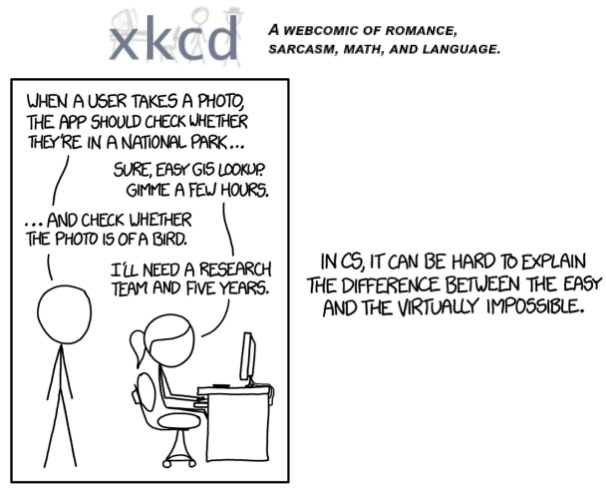

But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "bird photos"
1. Use DuckDuckGo to search for images of "forest photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

## Step 1: Download images of birds and non-birds

In [ ]:
from duckduckgo_search import ddg_images
# fastai.vision.all must be imported before fastcore.all on Intel Macs. Kills kernels
# otherwise, don't know why (as of Aug. 2022, might have a fix later)
from fastai.vision.all import *
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for {max_images} '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [ ]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 1 'bird photos'


'http://www.wallpapergeeks.com/wp-content/uploads/2014/02/Colorful-Bird-Perched-Wallpaper.jpg'

...and then download a URL and take a look at it:

In [ ]:
from fastdownload import download_url
dest = 'data/single/bird.jpg'

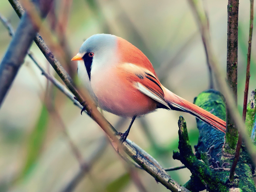

In [ ]:
download_url(urls[0], dest, show_progress=True)

im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

Searching for 1 'forest photos'


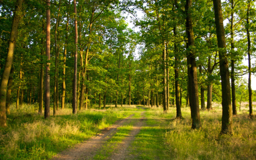

In [ ]:
download_url(search_images('forest photos', max_images=1)[0], 'data/single/forest.jpg', show_progress=True)
Image.open('data/single/forest.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [ ]:
searches = 'forest','bird'
path = Path('data/bird_or_not')
from time import sleep

num_images = 30

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    
    download_images(dest, urls=search_images(f'{o} photo', max_images=num_images))
    print(f'Downloaded {num_images} {o} photo')
    print('Sleeping 10 seconds to not overload server')
    sleep(10)  # Pause between searches to avoid over-loading server
    
    download_images(dest, urls=search_images(f'{o} sun photo', max_images=num_images))
    print(f'Downloaded {num_images} {o} sun photo')
    print('Sleeping 10 seconds to not overload server')
    sleep(10)
    
    download_images(dest, urls=search_images(f'{o} shade photo', max_images=num_images))
    print(f'Downloaded {num_images} {o} shade photo')
    print('Sleeping 10 seconds to not overload server')
    sleep(10)
    
    print(f'Resizing photos all {o} downloaded photos')
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 30 'forest photo'
Downloaded 30 forest photo
Sleeping 10 seconds to not overload server
Searching for 30 'forest sun photo'
Downloaded 30 forest sun photo
Sleeping 10 seconds to not overload server
Searching for 30 'forest shade photo'
Downloaded 30 forest shade photo
Sleeping 10 seconds to not overload server
Resizing photos all forest downloaded photos
Searching for 30 'bird photo'
Downloaded 30 bird photo
Sleeping 10 seconds to not overload server
Searching for 30 'bird sun photo'
Downloaded 30 bird sun photo
Sleeping 10 seconds to not overload server
Searching for 30 'bird shade photo'
Downloaded 30 bird shade photo
Sleeping 10 seconds to not overload server
Resizing photos all bird downloaded photos


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

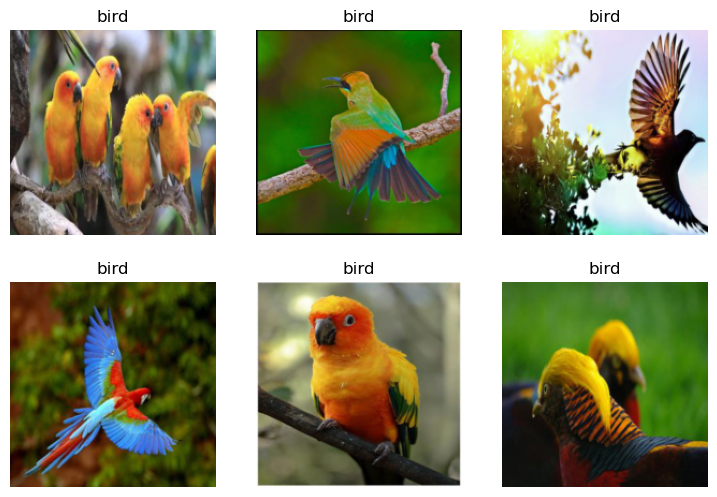

In [ ]:
data_loaders = DataBlock(
    #       input type, output type -> fastai can figure out the model you need with these specified
    blocks=(ImageBlock, CategoryBlock),
    # function used to find items to train on
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    # function used to get correct labels for each data point
    get_y=parent_label,
    # item transforms
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

data_loaders.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

DataLoaders are what Pytorch uses to grab a bunch of data at a time. They will be used to grab a bunch of data in batches and process batches in parallel while the model is training.

To get a feel for the available functions we can use, check out documentation at [docs.fast.ai](http://docs.fast.ai). The Tutorials are a great start for those new to the fast.ai library.

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [ ]:
# Fast AI learners combine models with data
learn = vision_learner(data_loaders, resnet18, metrics=error_rate)
learn.fine_tune(3)

/Users/demon_slayer/.pyenv/versions/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/demon_slayer/.pyenv/versions/mambaforge/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/demon_slayer/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.755640,0.584455,0.121212,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.156011,0.106816,0.090909,00:04
1,0.079956,0.048865,0.000000,00:03
2,0.052994,0.027702,0.000000,00:03


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

The model can be any model. Fast AI supports TIMM models, [timm.fast.ai](http://timm.fast.ai)

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [ ]:
# - learn.predict() needs images that are the same size as what it was trained on
# - 'bird.jpg' is the image at the top of this file we found and and downloaded
# - PILImage is a fast.ai helper class, Python Image Library
prediction,_,confidence = learn.predict(PILImage.create('data/single/bird.jpg'))
print(f"This is a: {prediction}.")
print(f"Confidence it's a bird: {confidence[0]:.4f}")

This is a: bird.
Confidence it's a bird: 1.0000


Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

Now we want to export the model for use.

In [ ]:
model_path = Path('models')
model_path.mkdir(exist_ok=True, parents=True)
learn.export(model_path/'resnet18.pkl')